In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [3]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances, jensen_shannon_divergence
from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
n_pc_samples = 2048

do_training = True
do_plotting = True
load_model = False
save_model = False
seed = 42
voxel_resolution = 32

ae_loss = 'emd'
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
experiment_name = 'ae_'+ ae_loss +'_1c_gan_'+ class_name +'_' + str(n_pc_samples) +  '_pts'

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/ae_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_1c_gan_chair_2048_pts'

In [7]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


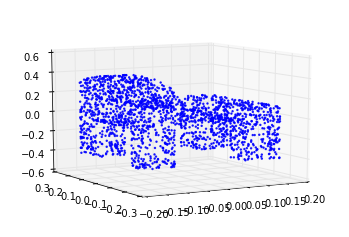

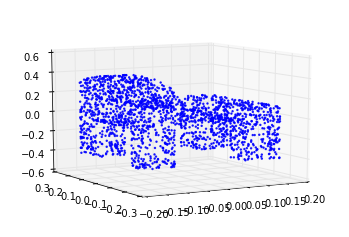

In [13]:
Point_Cloud(pclouds[0]).plot()

In [ ]:
# Load Auto-Encoder
reset_tf_graph()
ae_net_name = class_name + '_three_fc_dec_' + str(n_pc_samples) +  'pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
saved_epochs = read_saved_epochs(ae_conf.train_dir)
# last_epoch = saved_epochs[-1]
last_epoch = 200
ae.restore_model(ae_conf.train_dir, last_epoch, verbose=True)

In [9]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [10]:
reset_tf_graph()
init_lr = 0.00005
n_out = latent_codes.shape[1]
gan = LatentGAN(experiment_name, learning_rate=init_lr, n_output=[n_out])

In [11]:
if load_model:
    saved_epochs = read_saved_epochs(train_dir)
    last_epoch = saved_epochs[-1]
    gan.restore_model(train_dir, last_epoch, verbose=True)

In [12]:
n_syn_samples = training_data.num_examples  # Same number as original GT data.
max_epochs = 30
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}
train_stats = []
accum_syn_data = []

In [13]:
if do_training:
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss

        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        accum_syn_data.append(syn_data)
                
        if save_model:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)

1 (0.71073902913387987, 2.5195770315675929)
2 (0.096438143902376997, 5.4847727813976723)
3 (0.058346149280367285, 5.4686621019504216)
4 (0.15500148650783821, 3.8006832903663583)
5 (0.17156886389391535, 3.6448902795778824)
6 (0.23597476141364782, 3.3678626310105293)
7 (0.44498603605984044, 2.6845091285321536)
8 (0.85476677249742039, 1.8421859461189116)
9 (1.3361621155034775, 1.0591014703648203)
10 (1.4843839831000207, 0.71048327380378773)
11 (1.4553922478784651, 0.67526166991099412)
12 (1.4246631172679414, 0.68997517648159257)
13 (1.3997036178640072, 0.68974037578441949)
14 (1.3957755813662638, 0.69175468235207882)
15 (1.3955934471732019, 0.69588290084928472)
16 (1.3940066963234203, 0.68869924025247564)
17 (1.3910293187071012, 0.6981855406857177)
18 (1.3933527589644361, 0.6911328178924202)
19 (1.3899637716728568, 0.69314084637085061)
20 (1.3899010899882989, 0.6980700156832701)
21 (1.3909427815635733, 0.69074620136478604)
22 (1.3901639696735664, 0.69594955524342172)
23 (1.389357750047773

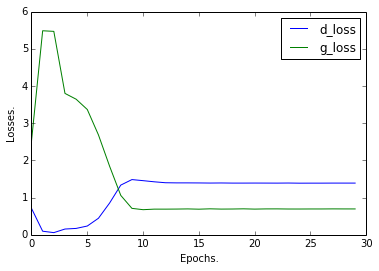

In [14]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('AE GAN: %s training.' %(class_name,))
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Losses.')

In [ ]:
epoch_to_check = 7
check_data = accum_syn_data[epoch_to_check]
save_out = osp.join(synthetic_data_out_dir, 'ae_trained_200eps_512gen_' + experiment_name + '_epoch_' + str(epoch_to_check))
np.savez(save_out, check_data)

In [106]:
jsd = []
emd_dists = []

# from general_tools.simpletons import iterate_in_chunks

for sdata in accum_syn_data:    
    sdata_r = sdata[:1000] # reduced
    for i, pc in enumerate(sdata_r): # in u sphere
        sdata_r[i] = Point_Cloud(pc).center_in_unit_sphere().points
        
    _, s_var = entropy_of_occupancy_grid(sdata_r, voxel_resolution)
    jsd.append(jensen_shannon_divergence(gt_voxel_rv,  s_var))
    emd_dists.append(point_cloud_distances(sdata_r, 10, gan.sess, 'emd'))
mean_emd_dists = [np.mean(i) for i in emd_dists]

In [107]:
print mean_emd_dists, jsd

[170.24316] [0.12697391728662391]


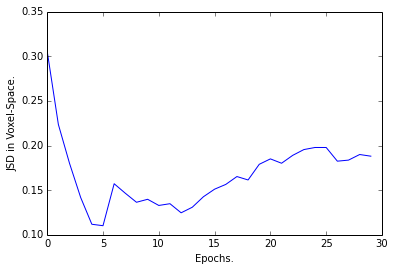

In [74]:
plt.plot(range(len(jsd)), jsd)
plt.xlabel('Epochs.')
plt.ylabel('JSD in Voxel-Space.')

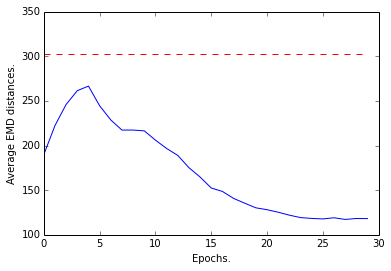

In [75]:
plt.xlabel('Epochs.')
plt.ylabel('Average EMD distances.')
plt.plot(range(len(mean_emd_dists)), mean_emd_dists)
plt.plot(range(len(mean_emd_dists)), np.ones(len(mean_emd_dists)) * 302.4, '--r' )

In [109]:
# epoch_to_check = 7

# check_data = accum_syn_data[epoch_to_check]
# rids = np.random.choice(range(len(check_data)), size=5, replace=False)
# print rids
# for i in range(5):
#     Point_Cloud(check_data[rids[i]]).plot()
    
save_out = osp.join(synthetic_data_out_dir, 'ae_trained_200eps_512gen_' + experiment_name + '_epoch_' + str(epoch_to_check))
np.savez(save_out, check_data)

In [ ]:
# plt.plot(range(len(entropies)), entropies)
# plt.plot(range(len(entropies)), np.ones(len(entropies)) * 0.074, '--r' )
# plt.xlabel('Epochs.')
# plt.ylabel('Mean Entropy.')

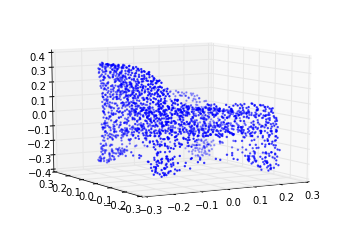

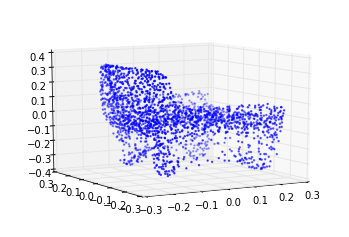

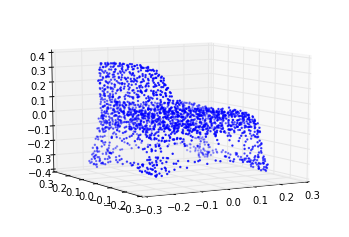

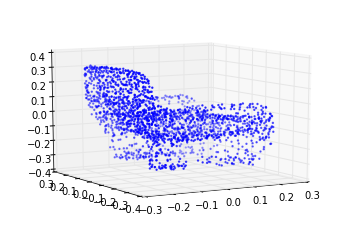

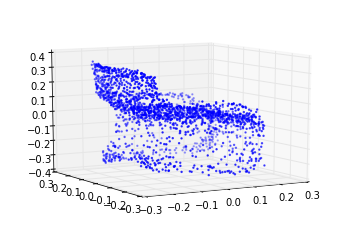

In [47]:
for i in range(5):
    gz = gan.generate(1, noise_params)
    Point_Cloud(ae.decode(gz)[0]).plot()

In [53]:
s_data__ = gan.generate(500, noise_params)
s_data__ = ae.decode(s_data__)
_, s_var = entropy_of_occupancy_grid(s_data__, 32)
print jensen_shannon_divergence(gt_voxel_rv, s_var)

0.198022063592
